## Training Binding Energy Models for -H, -COOH and -H + -COOH

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.db import connect
import sys
import os

In [3]:
import sys
sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from functions import prepare_dataset, learning_curve, train_XGB_model

In [4]:
db_folder = "../DFT_data/"
features_folder = "../csv_features/"

# Setting reference energies
The example reaction we're using is: 
$$ HCOOH (l) + * \rightleftharpoons  ^*COOH + (H^+ + e^-)$$
Where $HCOOH (l)$ is used as a reference. This gives an expression of the electronic binding energy as:
$$ \Delta E = E_{^*COOH} - E_{CO_2 (g)} - \frac{1}{2} E_{H_2 (g)} - E_* $$

A single electronic DFT energy (E) can be converted to a Gibbs energy!
$$ G = E + ZpE + \int_{0}^{T} C_p dT - TS $$

For example, with $*COOH$:
$$ G_{^*COOH} = E_{^*COOH} + ZPE_{^*COOH} + C_{p^*COOH} - T \cdot S_{^*COOH} $$

Instead of correcting each species individually, we can just sum all the ZpE's, delta Cp's and T*delta S:
$$ \Delta G = \Delta E + \Delta ZpE + \Delta C_p - T\cdot \Delta S $$

Samme fortegn som i ligning 2.

$$ \Delta G = \Delta E + Constant $$

$$ Constant = \Delta ZpE + \Delta C_p - T\cdot \Delta S $$

### Reaction 1: COOH Adsorption

$$ HCOOH (l) + * \rightleftharpoons  ^*COOH + (H^+ + e^-)$$
Electronic binding energy:
$$ \Delta E = E_{^*COOH} - E_{HCOOH (l)} - E_* + \frac{1}{2} E_{H_2 (g)} - eU$$
We'll have the model predict just the non-voltage-dependant part:
$$ \Delta E = E_{^*COOH} - E_{HCOOH (l)} - E_* + \frac{1}{2} E_{H_2 (g)} $$

### Reaction 2: H Adsorption

$$ H^+ + e^- + * \rightleftharpoons  ^*H $$
Electronic binding energy:
$$ \Delta E = E_{^*H} - E_* - \frac{1}{2} E_{H_2 (g)} + eU $$
We'll have the model predict just the non-voltage-dependant part:
$$ \Delta E = E_{^*H} - E_* - \frac{1}{2} E_{H_2 (g)}$$

### Reaction 3: H and COOH Adsorption ?

I should be able to make the equation for $\Delta E$

$$ HCOOH (l) + * \rightleftharpoons  ^*(COOH+H) $$
Electronic binding energy:
$$ \Delta E = E_{^*(COOH+H)} - E_{HCOOH (l)} - E_* $$
There is no voltage-dependence


### Reaction 4: CO Adsorption

$$ CO (g) + * \rightleftharpoons  ^*CO $$
Electronic binding energy:
$$ \Delta E = E_{^*CO} - E_{CO (g)} - E_* $$

This doesn't depend on voltage and it isn't the way *CO is removed, therefore is is not needed.

### Here's all the data

In [3]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab  = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

## COOH features

In [7]:
### Summing up all the Approximation Factors for COOH
ZpE_sum  = AF["bound_COOH"]["ZPE"]  - AF["HCOOH"]["ZPE"]  + 1/2*AF["H2"]["ZPE"]
CpdT_sum = AF["bound_COOH"]["CpdT"] - AF["HCOOH"]["CpdT"] + 1/2*AF["H2"]["CpdT"]
TS_sum   = AF["bound_COOH"]["TS"]   - AF["HCOOH"]["TS"]   + 1/2*AF["H2"]["TS"] #Figure the signs out
correction_constant_COOH = ZpE_sum + CpdT_sum - TS_sum

def correct_DFT_energy_COOH(correction_constant, molecules_dict, E_COOH, E_slab):
    DeltaE = E_COOH - molecules_dict["CH2O2"] + 1/2*molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

In [ ]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_COOH = 'COOH_C_adsorbed_out.db'

# Set free energies of Pt(111) *OH and O* adsorption
#G_COOH_Pt111 = 
## NOTE: This referencing will be made differently now - REFER TO IMAGE OF JACKS NOTES TO 

# Initiate dictionary with to convert DFT adsorption energies to free energies
#ref = {}
#
## Load Pt(111) databases
#with connect(db_folder + f'single_element_slabs_out.db') as db_slab,\
#     connect(db_folder + f'single_element_COOH_C_adsorbed_out.db') as db_COOH: #pure_metals hedder single_element nu
#
#    # Get DFT energies of pure slab, slab with *COOH
#    E_slab = db_slab.get('energy', Pt=45, C=0, H=0, O=0).energy
#    E_COOH = db_COOH.get('energy', Pt=45).energy
#
#    # Set references for each adsorbate
#    #ref['COOH'] = -(E_COOH - E_slab) + G_COOH_Pt111

# Initiate feature readers
reader_COOH = OntopStandard111(metals)

site_ids_COOH = [16, 17, 18]

# Initiate counters of rejected samples
rejected_COOH = 0

# Writer headers to files
with open(f'{features_folder}COOH_features.csv', 'w') as file_COOH:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_COOH}row')
    file_COOH.write(",".join(column_names))
    
## Writer headers to files
#with open(f'{features_folder}COOH_features.csv', 'w') as file_COOH: # For some reason this puts in a space before all column names except for the first. Example: " feature1"
#    file_COOH.write(",".join([f"feature{n}" for n in range(20)]) + f',G_ads(eV),slab db row,{db_name_COOH}row')
    

# Load HEA(111) databases
with connect(f'{db_folder}{db_name_COOH}') as db_COOH,\
     connect(f'{db_folder}slabs_out.db') as db_slab,\
     open(f'{features_folder}COOH_features.csv', 'a') as file_COOH:

    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0):

        # Iterate through the two adsorbates
        for ads in ['COOH']:

            # Set adsorbate-specific parameters
            if ads == 'COOH':
                db = db_COOH
                kw = {'C':1, 'O': 2, 'H': 1}
                db_name = db_name_COOH
                out_file = file_COOH

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):

                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:

                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='C')

                    # If the adsorbate is *COOH
                    if ads == 'COOH':

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_COOH += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_COOH.get_features(slab, radius=2.6)

                    # Get adsorption energy
                    #E_ads = row.energy - row_slab.energy + ref[ads] # THIS IS WHERE WE PUT IN THE NEW FORMULA
                    E_ads = correct_DFT_energy_COOH(correction_constant_COOH, molecules_dict, row.energy, row_slab.energy) # This is the new formula
                    #print(f"E_ads: {E_ads:.2f}")
                    # Write output to file
                    features = ','.join(map(str, features))
                    out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in') #{db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected COOH samples: ', rejected_COOH)

## H features


In [10]:
### Summing up all the Approximation Factors for H
ZpE_sum  = AF["bound_H"]["ZPE"]  - 1/2 * AF["H2"]["ZPE"] # Stokiometrien er bevaret! Tak, Oliver
CpdT_sum = AF["bound_H"]["CpdT"] - 1/2 * AF["H2"]["CpdT"]
TS_sum   = AF["bound_H"]["TS"]   - 1/2 * AF["H2"]["TS"]
correction_constant_H = ZpE_sum + CpdT_sum - TS_sum

def correct_DFT_energy_H(correction_constant, molecules_dict, E_H, E_slab):
    DeltaE = E_H - 1/2*molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

In [ ]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_H = 'H_out.db' #FIND FILEN FREM

# Initiate feature readers
reader_H = FccStandard111(metals) #Hollow sites

site_ids_H = [16, 17, 18]

# Initiate counters of rejected samples
rejected_H = 0

# Writer headers to files
with open(f'{features_folder}H_features.csv', 'w') as file_H:
    file_H.write(",".join([f"feature{n}" for n in range(55)]) + f',G_ads(eV),slab db row,{db_name_H}row')

# Load HEA(111) databases
with connect(f'{db_folder}{db_name_H}') as db_H,\
     connect(f'{db_folder}slabs_out.db') as db_slab,\
     open(f'{features_folder}H_features.csv', 'a') as file_H:

    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0):
        print(f"row_slab.id: {row_slab.id}")
        
        # Iterate through the adsorbate
        for ads in ['H']:

            # Set adsorbate-specific parameters
            if ads == 'H':
                db = db_H
                kw = {'C':0, 'O': 0, 'H': 1}
                db_name = db_name_H
                out_file = file_H
                ads_atom = "H"

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                print(f"row.id: {row.id}")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:

                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='H')

                    # If the adsorbate is *H
                    if ads == 'H': # Der er meget mere kode i "Load_prep_DFT_data" under H, måske mangler jeg noget
                        
                        atoms = atoms.repeat((3, 3, 1))
                        slab = Slab(atoms, ads=ads, ads_atom=ads_atom)
                        chemical_symbols = atoms.get_chemical_symbols()
                        #view(atoms)
                        H_index = [i for i, x in enumerate(chemical_symbols) if x == "H"][4]
                        
                        all_distances = atoms.get_distances([n for n in list(range(len(chemical_symbols))) if n != H_index], H_index)
                        site_ids_H = np.argpartition(all_distances, 2)[0:3]
                        site_ids_H = [x+1 if x>229 else x for x in site_ids_H] #Compensates for the removal of an H, so that the indices above 229 are not one too small
                        #print("site_ids_H: ", site_ids_H)
                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_H, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[H_index][:2]

                        # If the H is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_H += 1
                            continue

                        # Get features of structure
                        features = reader_H.get_features(slab, radius=2.6, site_ids=site_ids_H)

                        
                        ##### THIS IS THE FIRST THING FROM THE PUK CODE - BUT UNDERNEATH THERE IS SOMETHING MORE PROMISING ####
                        #atoms = atoms.repeat((3, 3, 1))
                        #chemical_symbols = atoms.get_chemical_symbols()
                        #H_index = chemical_symbols.index("H")[4]
                        #all_distances = atoms.get_distances(H_index)
                        #side_ids_H = np.argpartition(all_distances, 2)[0:3]
                        #
                        ## Get hollow site planar corner coordinates
                        #site_atoms_pos_orig = atoms.positions[site_ids_H, :2]
#
                        ## Get expanded triangle vertices
                        #site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)
#
                        ## Get position of adsorbate atom (with atom index XXX 20 XXX)
                        #ads_pos = atoms.positions[20][:2]
#
                        ## If the H is outside the expanded fcc triangle,
                        ## then it is most likely in an hcp site, that is not
                        ## being modeled
                        #if not inside_triangle(ads_pos, site_atoms_pos):
                        #    rejected_H += 1
                        #    continue
#
                        ## Get features of structure
                        #features = reader_H.get_features(slab, radius=2.6, site_ids=site_ids_H)
                        ##### THIS IS THE FIRST THING FROM THE PUK CODE - BUT UNDERNEATH THERE IS SOMETHING MORE PROMISING ####
            
            
            
                        ##### THE CODE IN HERE IS SHORTER THAN THAT IN THE PUK CODE - IT'S SUSPENDED #####
                        ## Get adsorption site elements as neighbors within a radius
                        #site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)
#
                        ## If the site does not consist of exactly one atom, then skip this sample
                        ## as the *OH has moved too far away from an on-top site
                        #try:
                        #    if len(site_elems) !=1:
                        #        rejected_H += 1
                        #        #slab.view()
                        #        continue
                        #except TypeError:
                        #    print(site_elems, site)
                        #    print(row_slab.id, row.id)
                        #    slab.view()
                        #    exit()
#
                        ## Get features of structure
                        ##print(f"row_slab.id: {row_slab.id}")
                        ##print(f"row.id: {row.id}")
                        #features = reader_H.get_features(slab, radius=2.6) #Her bliver den sur
                        ##### THE CODE IN HERE IS SHORTER THAN THAT IN THE PUK CODE - IT'S SUSPENDED #####
                
                    # Get adsorption energy
                    E_ads = correct_DFT_energy_H(correction_constant_H, molecules_dict, row.energy, row_slab.energy) # This is the new formula
                    print(f"E_ads: {E_ads:.2f}")
                    # Write output to file
                    features = ','.join(map(str, features))
                    out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in') #{db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected H samples: ', rejected_H)


## CO features

DFT data: CO_out.db #These match up

Slabs: slabs_out.db #These match up

\*CO binds to **on-top** sites



In [5]:
### Summing up all the Approximation Factors for COOH
ZpE_sum  = AF["bound_CO"]["ZPE"]  - AF["CO"]["ZPE"]
CpdT_sum = AF["bound_CO"]["CpdT"] - AF["CO"]["CpdT"]
TS_sum   = AF["bound_CO"]["TS"]   - AF["CO"]["TS"] #Figure the signs out
correction_constant_CO = ZpE_sum + CpdT_sum - TS_sum

def correct_DFT_energy_CO(correction_constant, molecules_dict, E_CO, E_slab):
    DeltaE = E_CO - molecules_dict["CO"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

In [ ]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_CO = 'CO_out.db'

# Initiate feature readers
reader_CO = OntopStandard111(metals)

site_ids_CO = [16, 17, 18]

# Initiate counters of rejected samples
rejected_CO = 0

# Writer headers to files
with open(f'{features_folder}CO_features.csv', 'w') as file_CO:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_CO}row')
    file_CO.write(",".join(column_names))
    
## Writer headers to files
#with open(f'{features_folder}CO_features.csv', 'w') as file_CO: # For some reason this puts in a space before all column names except for the first. Example: " feature1"
#    file_CO.write(",".join([f"feature{n}" for n in range(20)]) + f',G_ads(eV),slab db row,{db_name_CO}row')
    

# Load HEA(111) databases
with connect(f'{db_folder}{db_name_CO}') as db_CO,\
     connect(f'{db_folder}slabs_out.db') as db_slab,\
     open(f'{features_folder}CO_features.csv', 'a') as file_CO:
    print("A1")
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0):
        print("A2")
        # Iterate through the two adsorbates
        for ads in ['CO']:
            print("A3")
            # Set adsorbate-specific parameters
            if ads == 'CO':
                db = db_CO
                kw = {'C':1, 'O': 1, 'H': 0}
                db_name = db_name_CO
                out_file = file_CO

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()): # This line doesn't trigger
                print("A4")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:
                    print("A5")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='C')

                    # If the adsorbate is *CO
                    if ads == 'CO':
                        print("A5")
                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_CO += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_CO.get_features(slab, radius=2.6)
                        print("A6")
                    # Get adsorption energy
                    #E_ads = row.energy - row_slab.energy + ref[ads] # THIS IS WHERE WE PUT IN THE NEW FORMULA
                    E_ads = correct_DFT_energy_CO(correction_constant_CO, molecules_dict, row.energy, row_slab.energy) # This is the new formula
                    #print(f"E_ads: {E_ads:.2f}")
                    # Write output to file
                    features = ','.join(map(str, features))
                    print("A7")
                    out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')
                    print("A8")

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in') #{db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected CO samples: ', rejected_CO)

#### Soo do these energies make sense?

In [11]:
import csv
import statistics

# Specify the file path and name
csv_file = '../csv_features/CO_features.csv'

# Specify the target column header
target_column = "G_ads (eV)"

# Open the .csv file and read its contents using list comprehension
with open(csv_file, 'r') as file:
    # Create a CSV reader object
    reader = csv.DictReader(file)
    
    # Extract the values of the target column using list comprehension
    target_values = [float(row[target_column]) for row in reader]

# Calculate the mean and spread (standard deviation) of the target values
mean = statistics.mean(target_values)
spread = statistics.stdev(target_values)

# Print the mean and spread
print("Mean:", mean)
print("Spread (Standard Deviation):", spread)

Mean: -0.07772852485089464
Spread (Standard Deviation): 0.5517841094655194


In [9]:
with connect(f'{db_folder}{db_name_CO}') as db_CO:
    for row in db_CO.select('energy'):#, **kw, **row_slab.count_atoms()):
        print(row)

<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag5Au7Cu10Pd12Pt11CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag13Au5Cu12Pd7Pt8CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag13Au5Cu12Pd7Pt8CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag13Au5Cu12Pd7Pt8CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag13Au5Cu12Pd7Pt8CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag13Au5Cu12Pd7Pt8CO, keys=idx,slab_idx,site_idx>
<AtomsRow: formula=Ag13Au5Cu12Pd7Pt8CO,

## H+COOH features

In [ ]:
# Think about the logic for a bit

# 0: How would the energies work? Is it compared to free H and COOH and empty slab? I could write it to show Jack

# 1: Make a hollow site vector for the H atom
# 2: Make an on-top site vector for the COOH molecule

# 3: Save both of them seperately in .csv files
# 4: Load them seperately and combine them
# 5: Then train the model on the combined set

# 6: I'll need to make a similar vector for the numpy surface["atoms"] things. Maybe the thing with the lowest number of failure points is just smashing the vectors together lmao
# 7: Maybe I should call the features "H_feature1"

# Note: Det H atom vi er interesseret i er nummer #45
# Note: Der er 17 slabs 

I should be able to make the equation for $\Delta E$

$$ CO_2 (g) + \frac{1}{2} H_2 (g) + \frac{1}{2} H_2 (g) + *\rightleftharpoons  ^*(COOH+H) $$

$$ \Delta E = E_{^*(COOH+H)} - E_{CO_2 (g)} - \frac{1}{2} E_{H_2 (g)} - \frac{1}{2} E_{H_2 (g)} - E_* $$

#### Is that not an unfair comparison? $CO_2 (g)$ and  $ H_2 (g) $ should be more stable than HCOOH (l) 

$$ HCOOH (l) + * \rightleftharpoons  ^*(COOH+H) $$

$$ \Delta E = E_{^*(COOH+H)} - E_{HCOOH (l)} - E_* $$

In [49]:
### Summing up all the Approximation Factors for COOH
ZpE_sum  = AF["bound_COOH"]["ZPE"]  + AF["bound_H"]["ZPE"]  - AF["HCOOH"]["ZPE"]  
CpdT_sum = AF["bound_COOH"]["CpdT"] + AF["bound_H"]["CpdT"] - AF["HCOOH"]["CpdT"] 
TS_sum   = AF["bound_COOH"]["TS"]   + AF["bound_H"]["TS"]   - AF["HCOOH"]["TS"]   #Check, that the signs are correct
correction_constant_COOH_H = ZpE_sum + CpdT_sum - TS_sum

def correct_DFT_energy_COOH_H(correction_constant, molecules_dict, E_HplusCOOH, E_slab):
    DeltaE = E_HplusCOOH - molecules_dict["CO2"] - 1/2*molecules_dict["H2"] - 1/2*molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

def correct_DFT_energy_COOH_H(correction_constant, molecules_dict, E_HplusCOOH, E_slab):
    DeltaE = E_HplusCOOH - molecules_dict["CH2O2"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

## Making feature vectors based on H (With COOH)

In [ ]:
### Trying to make a H-vector from the H+COOH data

# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_COOH_H = 'COOH_H_adsorbed_all_sites_out.db' #FIND FILEN FREM

# Initiate feature readers
reader_COOH_H = FccStandard111(metals) #Hollow sites

site_ids_COOH_H = [16, 17, 18]

# Initiate counters of rejected samples
rejected_COOH_H = 0

# Writer headers to files
with open(f'{features_folder}COOH_H_Hvec_features.csv', 'w') as file_COOH_H:
    file_COOH_H.write(",".join([f"H_feature{n}" for n in range(55)]) + f',G_ads(eV),slab db row,{db_name_COOH_H}row')

# Load HEA(111) databases
with connect(f'{db_folder}{db_name_COOH_H}') as db_COOH_H,\
     connect(f'{db_folder}slabs_17_out.db') as db_slab,\
     open(f'{features_folder}COOH_H_Hvec_features.csv', 'a') as file_COOH_H:
    
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0):
        #print(f"row_slab.id: {row_slab.id}")
        
        # Iterate through the adsorbate
        for ads in ['H']:
            #print("A1")
            # Set adsorbate-specific parameters
            if ads == 'H':
                db = db_COOH_H
                kw = {'C':1, 'O': 2, 'H': 2} #Might need to change this to accomodate for the actual adsorbates
                db_name = db_name_COOH_H
                out_file = file_COOH_H
                ads_atom = "H"
                #print("A2")
            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()): # It would be really nice if this line said something instead of just not running...
                #print(f"row.id: {row.id}")
                #print("A3")
                # If symbols match up
                #print("row.symbols[:-len(ads)]", row.symbols[:-len(ads)])
                #print("row_slab.symbols", row_slab.symbols)
                all_ads = "HCOOH"
                if row.symbols[:-len(all_ads)] == row_slab.symbols: #Fix this line to accomodate for COOH+H
                    #print("A4")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='H')

                    # If the adsorbate is *H
                    if ads == 'H': # Der er meget mere kode i "Load_prep_DFT_data" under H, måske mangler jeg noget
                        
                        atoms = atoms.repeat((3, 3, 1))
                        slab = Slab(atoms, ads=ads, ads_atom=ads_atom)
                        chemical_symbols = atoms.get_chemical_symbols()
                        #view(atoms)
                        H_index = [i for i, x in enumerate(chemical_symbols) if x == "H"][4]
                        
                        all_distances = atoms.get_distances([n for n in list(range(len(chemical_symbols))) if n != H_index], H_index)
                        site_ids_H = np.argpartition(all_distances, 2)[0:3]
                        site_ids_H = [x+1 if x>229 else x for x in site_ids_H] #Compensates for the removal of an H, so that the indices above 229 are not one too small
                        #print("site_ids_H: ", site_ids_H)
                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_H, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[H_index][:2]

                        # If the H is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_COOH_H += 1
                            continue

                        # Get features of structure
                        features = reader_COOH_H.get_features(slab, radius=2.6, site_ids=site_ids_H)

                       
                    # Get adsorption energy
                    E_ads = correct_DFT_energy_COOH_H(correction_constant_COOH_H, molecules_dict, row.energy, row_slab.energy) # This is the new formula
                    #print(f"E_ads: {E_ads:.2f}")
                    # Write output to file
                    features = ','.join(map(str, features))
                    out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in') #{db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected COOH_H samples: ', rejected_COOH_H)


## Making feature vectors based on COOH (With H)

In [ ]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_COOH_H = 'COOH_H_adsorbed_all_sites_out.db'

# Initiate feature readers
reader_COOH_H = OntopStandard111(metals)

site_ids_COOH_H = [16, 17, 18]

# Initiate counters of rejected samples
rejected_COOH_H = 0

# Writer headers to files
with open(f'{features_folder}COOH_H_COOHvec_features.csv', 'w') as file_COOH_H:
    column_names = [f"COOH_feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_COOH_H}row')
    file_COOH_H.write(",".join(column_names))

# Load HEA(111) databases
with connect(f'{db_folder}{db_name_COOH_H}') as db_COOH_H,\
     connect(f'{db_folder}slabs_17_out.db') as db_slab,\
     open(f'{features_folder}COOH_H_COOHvec_features.csv', 'a') as file_COOH_H:

    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0):
        #print(f"row_slab.id: {row_slab.id}")
        
        # Iterate through the two adsorbates
        for ads in ['COOH']:

            # Set adsorbate-specific parameters
            if ads == 'COOH':
                db = db_COOH_H
                kw = {'C':1, 'O': 2, 'H': 2}
                db_name = db_name_COOH
                out_file = file_COOH_H

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                #print(f"row.id: {row.id}")
                
                # If symbols match up
                all_ads = "HCOOH"
                if row.symbols[:-len(all_ads)] == row_slab.symbols:

                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id) # Fjern H (atom 45) her
                    del atoms[45]
                    #new_atoms = Atoms(symbols=atoms.symbols[:-1], cell=atoms.cell)
                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='C')
                    
                    # If the adsorbate is *COOH
                    if ads == 'COOH':

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_COOH_H += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_COOH_H.get_features(slab, radius=2.6)

                    # Get adsorption energy
                    
                    E_ads = correct_DFT_energy_COOH_H(correction_constant_COOH_H, molecules_dict, row.energy, row_slab.energy) # This is the new formula
                    #print(f"E_ads: {E_ads:.2f}")
                    
                    # Write output to file
                    features = ','.join(map(str, features))
                    out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in') #{db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected COOH_H samples: ', rejected_COOH_H)

In [ ]:
### SET THE PATHS, FILES, ETC.
# Folder paths
features_folder = "../csv_features/"
db_folder       = "../DFT_data/"

# Specify name of databases
db_name_HEA      = "COOH_H_adsorbed_all_sites_out.db"
db_name_SWR      = "swim_ring_H_COOH_out.db"
db_name_slab_HEA = "slabs_17_out.db"
db_name_slab_SWR = "swim_ring_slabs_out.db"

#Specify name of the csv feature files - there'll be four then
feature_file_HEA_H    = "mixed_HEA_H.csv"
feature_file_HEA_COOH = "mixed_HEA_COOH.csv"
feature_file_SWR_H    = "mixed_SWR_H.csv"
feature_file_SWR_COOH = "mixed_SWR_COOH.csv"

# I should probably just run this function once for HEA and once for SWR
def features_from_mixed_sites(db_name_HEA, features_folder, feature_file_H, feature_file_COOH):
    """Make features from slabs with mixed-sites (H + COOH as neighbours). 
    Two sets of features will be made. One with the feature vector based on H and one based on COOH.
    They will be saved seperately to be combined later
    Combine the feature vectors and save them to be loaded easily"""

    # Kopier koden ind der laver H vector her
    # Skift filnavne ud


    # Kopier koden ind der laver COOH vector her
    # Skift filnavne ud

    return None

# Bagefter, når features er i orden:
# Lav en funktion, som håndterer sammenkobling af featuresne, så der kan trænes en model på det
# Lav en funktion, som træner modellen og gemmer den med et godt navn

# Load de opdaterede modeller rundtomkring

In [ ]:
## Perfect! Both H and COOH vectors have now been created from the same data! I'll traion the model in the other document "Training_E_models_OH_O_Mix.ipynb" because this document has gotten too long and slow.

## Making features based on **swim ring** data for H, COOH and H+COOH

In [ ]:
# Could I make a function for the feature writing? The code is replicated SO many times in this document
# In reality it's a simple case of filenames in and features in a file out
# Also some specifics for each adsorbate-type
# One function for H and one for COOH and one for each seperately could work

# In: data .db filename, slab .db filename, csv file name
# In: folder paths

In [5]:
# Import functions from functions.py
sys.path.append('../scripts')
from functions import features_from_DFT_data_H_and_COOH, calc_correction_constant_COOH, correct_DFT_energy_COOH, calc_correction_constant_H, correct_DFT_energy_H
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect

**HEA**: H and COOH seperately

In [ ]:
### ENERGY CORRECTIONS - BOTH IN ONE - COMBINE THEM

### SET THE PATHS, FILES, ETC.
# Folder paths
features_folder = "../csv_features/"
db_folder       = "../DFT_data/"

# Specify name of databases
db_name_H    = 'H_out.db'
db_name_COOH = 'COOH_C_adsorbed_out.db'
db_name_slab = "slabs_out.db"

#Specify name of the csv feature files
feature_file_H    = "H_DFT_features.csv"
feature_file_COOH = "COOH_DFT_features.csv"

### DO THE THING:
features_from_DFT_data_H_and_COOH(features_folder, db_folder, db_name_H, db_name_COOH, db_name_slab, feature_file_H, feature_file_COOH)

**Swim rings**: H and COOH seperately

In [ ]:
### ENERGY CORRECTIONS - BOTH IN ONE - COMBINE THEM

### SET THE PATHS, FILES, ETC.
# Folder paths
features_folder = "../csv_features/"
db_folder       = "../DFT_data/"

# Specify name of databases
db_name_H    = 'swim_ring_H_out.db'
db_name_COOH = 'swim_ring_COOH_out.db'
db_name_slab = 'swim_ring_slabs_out.db'

#Specify name of the csv feature files
feature_file_H    = "swim_ring_H_DFT_features.csv"
feature_file_COOH = "swim_ring_COOH_DFT_features.csv"

### DO THE THING:
features_from_DFT_data_H_and_COOH(features_folder, db_folder, db_name_H, db_name_COOH, db_name_slab, feature_file_H, feature_file_COOH)

## Training $\Delta G$ models (Note: This is stolen code from my own PUK) (Now modified)

#### Import packages

In [5]:
import warnings
warnings.filterwarnings('ignore')

import xgboost;
from xgboost import XGBRegressor;
import pandas as pd;
from sklearn.model_selection import train_test_split;
from xgboost import plot_importance;
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

import random
random.seed(1)
np.random.seed(1)

import time

figure_folder = "../figures/"

### H models - With both **HEA** and **Swim ring** data

I'll have to divide each dataset (HEA and swim ring) into train, val, test seperately so that I'm sure to get a bit of both in the test

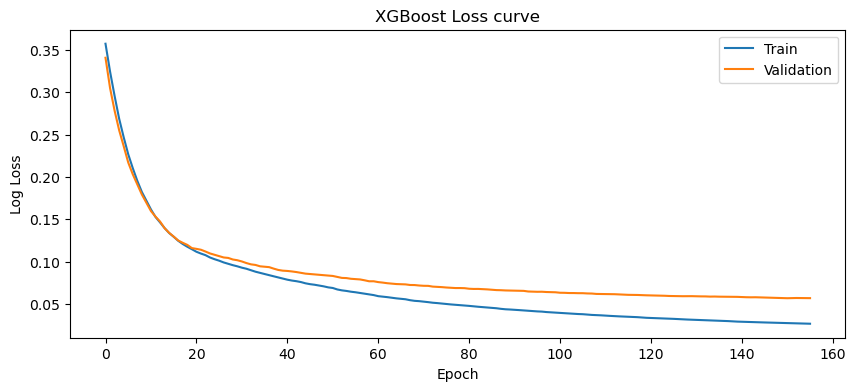

Training score:  0.9733974603474527
Validation score:  0.846600654544942
Test score:  0.8939746341998906


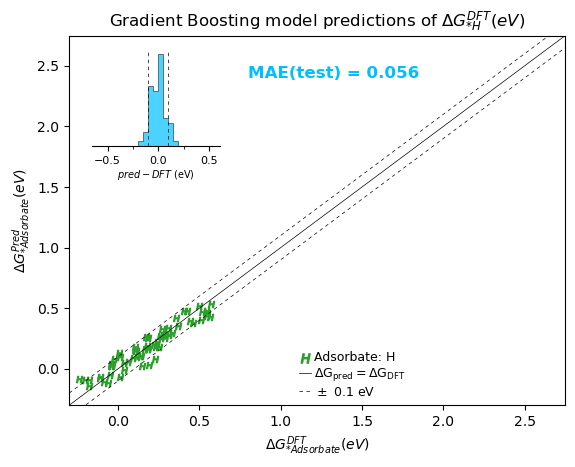

In [8]:
feature_folder = "../csv_features/"
# Define the data filenames
HEA_H_filename = "H_DFT_features.csv"
swim_ring_H_filename = "swim_ring_H_DFT_features.csv"
model_name = "H_HEA_SWR"
adsorbate = "H"

# Fish out the data
X_HEA_train, y_HEA_train, X_HEA_val, y_HEA_val, X_HEA_test, y_HEA_test = prepare_dataset(feature_folder, HEA_H_filename)
X_SWR_train, y_SWR_train, X_SWR_val, y_SWR_val, X_SWR_test, y_SWR_test = prepare_dataset(feature_folder, swim_ring_H_filename)

# Combine the data
X_train, y_train = pd.concat([X_HEA_train, X_SWR_train]), pd.concat([y_HEA_train, y_SWR_train])
X_val, y_val     = pd.concat([X_HEA_val  , X_SWR_val])  , pd.concat([y_HEA_val  , y_SWR_val])
X_test, y_test   = pd.concat([X_HEA_test , X_SWR_test]) , pd.concat([y_HEA_test , y_SWR_test])

# Train model on the mix - should also show the plot or something.
train_XGB_model(model_name, adsorbate, X_train, y_train, X_val, y_val, X_test, y_test)


### COOH models - With both **HEA** and **Swim ring** data

I'll have to divide each dataset (HEA and swim ring) into train, val, test seperately so that I'm sure to get a bit of both in the test

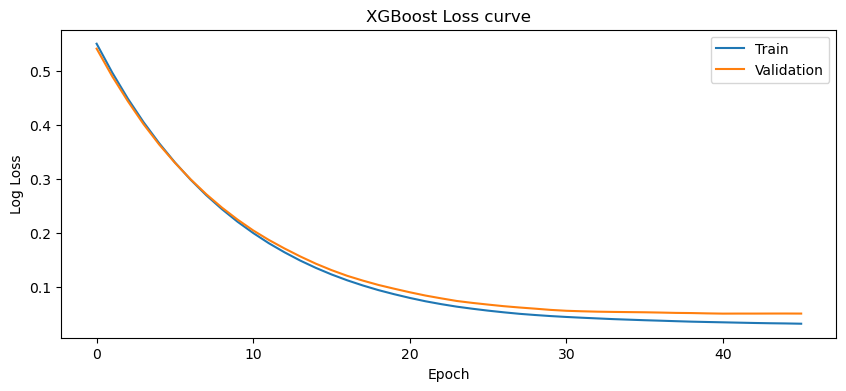

Training score:  0.9896629504330033
Validation score:  0.9779284996324044
Test score:  0.9735062617733838


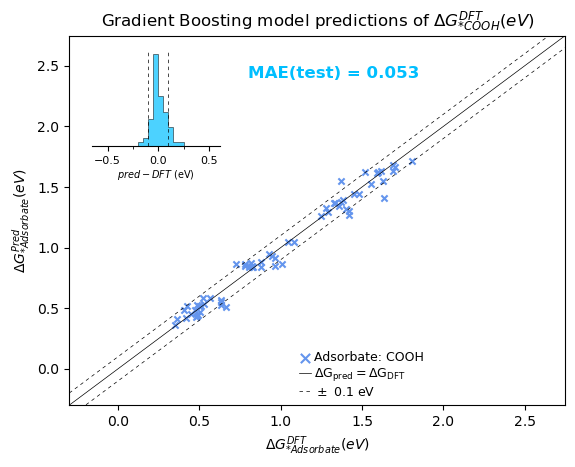

In [9]:
feature_folder = "../csv_features/"
# Define the data filenames
HEA_COOH_filename = "COOH_DFT_features.csv"
swim_ring_COOH_filename = "swim_ring_COOH_DFT_features.csv"
model_name = "COOH_HEA_SWR"
adsorbate = "COOH"

# Fish out the data
X_HEA_train, y_HEA_train, X_HEA_val, y_HEA_val, X_HEA_test, y_HEA_test = prepare_dataset(feature_folder, HEA_COOH_filename)
X_SWR_train, y_SWR_train, X_SWR_val, y_SWR_val, X_SWR_test, y_SWR_test = prepare_dataset(feature_folder, swim_ring_COOH_filename)

# Combine the data
X_train, y_train = pd.concat([X_HEA_train, X_SWR_train]), pd.concat([y_HEA_train, y_SWR_train])
X_val, y_val     = pd.concat([X_HEA_val  , X_SWR_val])  , pd.concat([y_HEA_val  , y_SWR_val])
X_test, y_test   = pd.concat([X_HEA_test , X_SWR_test]) , pd.concat([y_HEA_test , y_SWR_test])

# Train model on the mix - should also show the plot or something.
train_XGB_model(model_name, adsorbate, X_train, y_train, X_val, y_val, X_test, y_test)


### Mixed-site H + COOH models - With both **HEA** and **Swim ring** data

I'll have to divide each dataset (HEA and swim ring) into train, val, test seperately so that I'm sure to get a bit of both in the test

# No longer used

In [26]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

In [27]:
# Save model in the /models folder
XGBModel_H.save_model("../models/"+"H.model")

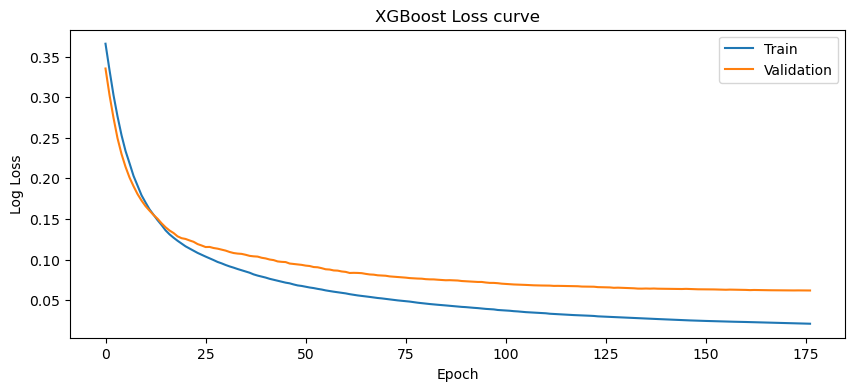

Training score:  0.983806440998632
Validation score:  0.8754580055573999


In [28]:
learning_curve(XGBModel_H)

score = XGBModel_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

In [9]:
# Trying to train a better model - Randomsearching parameters
if True:
    from sklearn.model_selection import RandomizedSearchCV
    
    params = { 'max_depth': list(range(3, 10)),
               'learning_rate': np.arange(0.01, 0.3, 0.0001),
               'subsample': np.arange(0.5, 1.0, 0.001),
               'colsample_bytree': np.arange(0.4, 1.0, 0.001),
               'colsample_bylevel': np.arange(0.4, 1.0, 0.001),
               'n_estimators': [150],
               'n_jobs': [8],
               'eval_metric': ["mae"]}
               #'objective': 'binary:logistic'}
    
    xgbr = XGBRegressor(seed = 42)
    clf = RandomizedSearchCV(estimator=xgbr,
                             param_distributions=params,
                             scoring='neg_mean_absolute_error',
                             n_iter=50,
                             verbose=2)
    clf.fit(X_train, y_train)
    print("Best parameters:", clf.best_params_)
    print("Lowest -MAE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bylevel=0.7000000000000003, colsample_bytree=0.44000000000000006, eval_metric=mae, learning_rate=0.29649999999999826, max_depth=6, n_estimators=150, n_jobs=8, subsample=0.8830000000000003; total time=   0.1s
[CV] END colsample_bylevel=0.7000000000000003, colsample_bytree=0.44000000000000006, eval_metric=mae, learning_rate=0.29649999999999826, max_depth=6, n_estimators=150, n_jobs=8, subsample=0.8830000000000003; total time=   0.1s
[CV] END colsample_bylevel=0.7000000000000003, colsample_bytree=0.44000000000000006, eval_metric=mae, learning_rate=0.29649999999999826, max_depth=6, n_estimators=150, n_jobs=8, subsample=0.8830000000000003; total time=   0.1s
[CV] END colsample_bylevel=0.7000000000000003, colsample_bytree=0.44000000000000006, eval_metric=mae, learning_rate=0.29649999999999826, max_depth=6, n_estimators=150, n_jobs=8, subsample=0.8830000000000003; total time=   0.1s
[CV] END colsample_bylevel=0.7

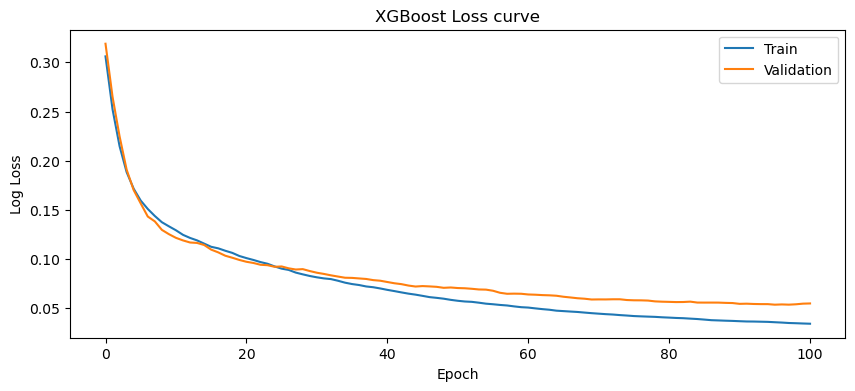

Training score:  0.9538899179256124
Validation score:  0.86503811309803
Test score:  0.8740303549218313


In [13]:
### Using the best parameters found from random_search

eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_H_Pro =  XGBRegressor(learning_rate = 0.224 #learning rate
                                , max_depth = 3     #maximum tree depth
                                , n_estimators = 150 #number of boosting rounds
                                #, early_stopping_rounds = 5
                                , n_jobs = 8 #number of threads
                                , subsample = 0.676
                                , colsample_bytree = 0.709
                                , colsample_bylevel = 0.786
                                , use_label_encoder = False)

XGBModel_H_Pro.fit(X_train, y_train, eval_set = eval_set
                  , early_stopping_rounds = 5
                  , eval_metric = ["mae"]
                  , verbose = False)

learning_curve(XGBModel_H_Pro)

score = XGBModel_H_Pro.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_H_Pro.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

score = XGBModel_H_Pro.score(X_test, y_test) #Det må man ikke før den er blevet trænet
print("Test score: ", score)

In [31]:
### Train the model a 100 times to get an accurate MAE:
MAE_H_Pro = []

for iteration in range(100):
    #shuffle and split
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

    eval_set = [(X_train, y_train), (X_val, y_val)]
    XGBModel_H_Pro =  XGBRegressor(learning_rate = 0.239 #learning rate
                                    , max_depth = 4     #maximum tree depth
                                    , n_estimators = 150 #number of boosting rounds
                                    #, early_stopping_rounds = 5
                                    , n_jobs = 8 #number of threads
                                    , subsample = 0.956
                                    , colsample_bytree = 0.46
                                    , colsample_bylevel = 0.61
                                    , use_label_encoder = False)
    
    XGBModel_H_Pro.fit(X_train, y_train, eval_set = eval_set
                      , early_stopping_rounds = 5
                      , eval_metric = ["mae"]
                      , verbose = False)
        
    MAE_H_Pro.append(return_mae(XGBModel_H_Pro, X_test, y_test))
    
print("The average MAE of the \"XGBModel_H_Pro\" model is: ", np.mean(MAE_H_Pro))

The average MAE of the "XGBModel_H_Pro" model is:  0.05397279866288249


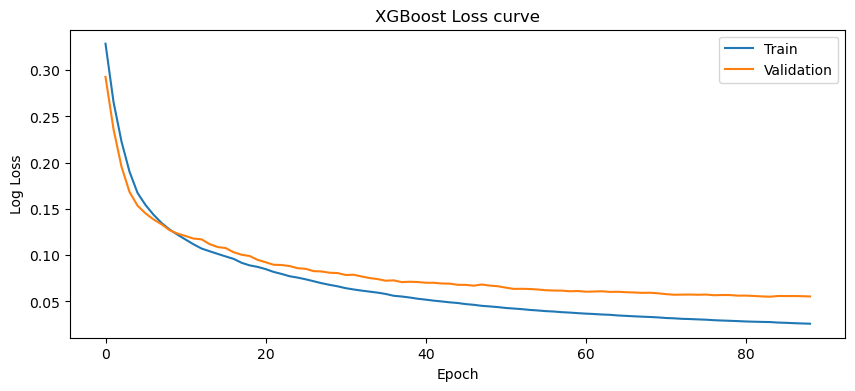

Training score:  0.9755988140889601
Validation score:  0.8940066213243291
Test score:  0.9105188394786699


In [32]:
learning_curve(XGBModel_H_Pro)

score = XGBModel_H_Pro.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_H_Pro.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

score = XGBModel_H_Pro.score(X_test, y_test) #Det må man ikke før den er blevet trænet
print("Test score: ", score)

In [33]:
# Save model in the /models folder
XGBModel_H_Pro.save_model("../models/"+"H.model")

## Parity plot

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

figure_folder = "../figures/DeltaG_models/"

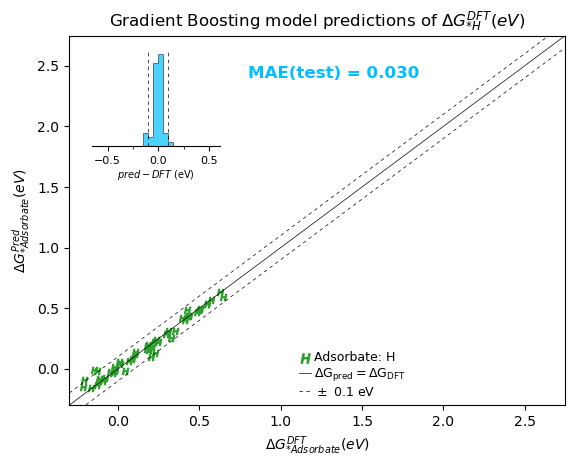

In [35]:
single_parity_plot(XGBModel_H, X_test, y_test, "H", "H") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

### Load COOH data

In [60]:
feature_folder = "../csv_features/"
filename = "COOH_features.csv"

# Load datasets
COOH_df = pd.read_csv(feature_folder + filename)

all_cols = COOH_df.columns
#Seperate the energies and remove the useless columns

X = COOH_df.loc[:, :all_cols[-4]]
y = COOH_df[["G_ads (eV)"]] #Der er åbenbart et mellemrum her, det forsvinder måske, hvis jeg laver features igen

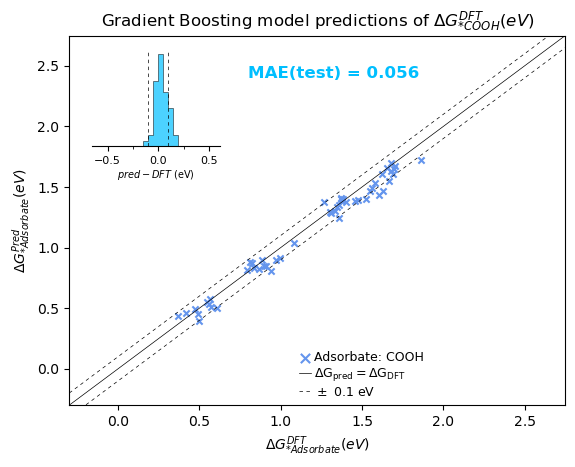

In [62]:
# Prepare dataset
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Train model
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_COOH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_COOH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 50
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Test model
single_parity_plot(XGBModel_COOH, X_test, y_test, "COOH", adsorbate = "COOH")

# Save model
XGBModel_COOH.save_model("../models/"+"COOH.model")

In [63]:
### Train the model a 100 times to get an accurate MAE:
MAE_COOH = []

for iteration in range(100):
    #shuffle and split
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

    # Train model
    eval_set = [(X_train, y_train), (X_val, y_val)]
    XGBModel_COOH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

    XGBModel_COOH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 50
                       , eval_metric = ["mae"]
                       , verbose = False) #evals
    MAE_COOH.append(return_mae(XGBModel_COOH, X_test, y_test))
    
print("The average MAE of the \"XGBModel_COOH\" model is: ", np.mean(MAE_COOH))

The average MAE of the "XGBModel_COOH" model is:  0.05845962984775507


### Load CO data

In [36]:
# Load dataset
CO_df = prepare_csv(feature_folder, "CO_features.csv", 4) #CO kalder vi 4

all_cols = CO_df.columns
#Seperate the energies and remove the useless columns

X = CO_df.loc[:, :all_cols[-4]]
y = CO_df[["G_ads (eV)"]] #Der er åbenbart et mellemrum her, det forsvinder måske, hvis jeg laver features igen

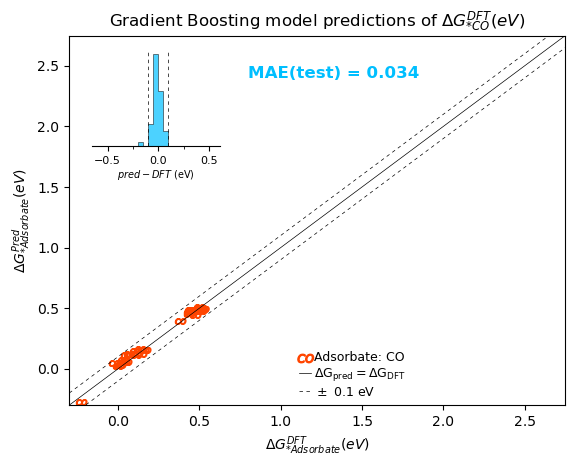

In [41]:
# Prepare dataset
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Train model
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_CO =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_CO.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 50
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Test model
single_parity_plot(XGBModel_CO, X_test, y_test, "CO", adsorbate = "CO")

# Save model
XGBModel_CO.save_model("../models/"+"CO.model")

In [42]:
### Train the model a 100 times to get an accurate MAE:
MAE_CO = []

for iteration in range(100):
    #shuffle and split
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

    # Train model
    eval_set = [(X_train, y_train), (X_val, y_val)]
    XGBModel_CO =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

    XGBModel_CO.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 50
                       , eval_metric = ["mae"]
                       , verbose = False) #evals
    MAE_CO.append(return_mae(XGBModel_CO, X_test, y_test))
    
print("The average MAE of the \"XGBModel_CO\" model is: ", np.mean(MAE_CO))

The average MAE of the "XGBModel_CO" model is:  0.04166952634859876


### Load COOH+H data

In [ ]:
# Think about the logic for a bit

# 1: Make a hollow site vector for the H atom
# 2: Make an on-top site vector for the COOH molecule

# 3: Save both of them seperately in .csv files
# 4: Load them seperately and combine them
# 5: Then train the model on the combined set

# 6: I'll need to make a similar vector for the numpy surface["atoms"] things. Maybe the thing with the lowest number of failure points is just smashing the vectors together lmao
# 7: Maybe I should call the features "H_feature1"

### Time to load the models from scratch and throw test-vectors at them

In [ ]:
# Make all feature vectors for all on-top and hollow sites
all_on_top_OH_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y) for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(20)])
all_hollow_H_df  = pd.DataFrame([hollow_site_vector(surface, site_x, site_y, adsorbate = "H") for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(56)])

all_on_top_OH_DM = pandas_to_DMatrix(all_on_top_OH_df)

H_Energies = on_top_site_model.predict(all_on_top_OH_DM)